# Image Analysis with Python - <font color='teal'>Tutorial Pipeline</font>

*originally created in 2016*<br>
*updated and converted to a Jupyter notebook in 2017*<br>
*updated and converted to python 3 in 2018*<br>
*by Jonas Hartmann (Gilmour group, EMBL Heidelberg)*<br>

##  Table of Contents

1. [About this Tutorial](#about)
2. [Setup](#setup)
3. [Importing Modules & Packages](#import)
4. [Loading & Handling Image Data](#load)
5. [Preprocessing](#prepro)
6. [Manual Thresholding & Threshold Detection](#thresh)
7. [Adaptive Thresholding](#adaptive)
8. [Improving Masks with Binary Morphology](#morpho)
9. [Connected Components Labeling](#label)
10. [Cell Segmentation by Seeding & Expansion](#seg)
11. [Postprocessing: Removing Cells at the Image Border](#postpro)
12. [Identifying Cell Edges](#edges)
13. [Extracting Quantitative Measurements](#measure)
14. [Simple Analysis & Visualization](#analysis)
15. [Writing Output to Files](#write)
16. [Batch Processing](#batch)

##  About this Tutorial <a id=about></a>

*This tutorial aims to teach the basics of (bio-)image processing with python, in particular the analysis of fluorescence microscopy data. The tutorial is self-explanatory and follows a "learning by doing" philosophy. It consists of step by step instructions that guide students through the construction of a 2D single-cell segmentation pipeline.*


#### Instructions

- This notebook contains detailed instructions on how to program a pipeline that can segment cells in 2D fluorescence microscopy images of a developing tissue.


- Simply go through the instructions step by step and try to implement each step as best as you can.
    - By doing so, you will learn about key concepts of (bio-)image processing with python!


- If you are stuck...
    - ...first think some more about the problem and see if you can get yourself unstuck.
    - ...search the internet (in particular Stack Overflow) for a solution to your problem.
    - ...if you are working through this tutorial in class, ask one of the tutors for help.
    - ...if nothing else helps, you can have a look at the solutions (`image_analysis_tutorial_solutions.py`) for inspiration.
        - **Beware:** If you simply copy a solution, you will learn *nothing* in the process! Use the solutions only as an inspiration for implementing your own version and make sure you fully understand how the solution works!
        
        
- Some exercises are labeled as 'BONUS' exercises. It is up to you whether you'd like to complete them. 
    - If things are going slowly, you may want to skip them and come back to them later.


#### Background 

The aim is to construct a pipeline for the identification and segmentation of cells in 2D confocal fluorescence microscopy images of a tissue with labeled membranes. This is among the most common tasks in bio-image analysis and is often essential for the extraction of useful quantitative information from microscopy data.

The pipeline is constructed based on provided example images (see `example_data` directory), which are single-color spinning-disk confocal micrographs (objective: `40X 1.2NA W`) of cells in live zebrafish embryos in early development (~10h post fertilization), fluorescently labeled with a membrane-localized fusion protein (`mNeonGreen:Ggamma9`).

##  Setup <a id=setup></a>

#### Development Environment

- Depending on your preferences, there are several alternatives for implementing this pipeline:
    1. Implement it directly in this Jupyter notebook *[recommended]*.
    2. Implement it in your favorite Integrated Development Environment (IDE) like PyCharm.
    3. Old School: Implement it in a text editor (like Vim...) and run it on the terminal.


#### Example Data

Make sure that you have downloaded the example image data (`example_cells_1.tif` and `example_cells_2.tif`), which should be located in the directory `example_data`, which in turn should be in the same directory as this notebook.


#### Python version

- The solutions were last tested with **python 3.9**, but any version of python 3 should work without changes
- To install python, jupyter notebook and the required modules, we recommend the **Anaconda Distribution**. The installer can be downloaded [here](https://www.anaconda.com/download/).


#### Required modules

- Make sure the following modules are installed before you get started:
    - numpy
    - scipy
    - matplotlib
    - scikit-image
    - ipywidgets
- All required modules come pre-installed if you are using the **[Anaconda distribution](https://www.anaconda.com/download/)** of python.

*Everything ready? Yes? Then let's get started!*

----

## Importing Modules & Packages <a id=import></a>

Let's start by importing the package NumPy, which enables the manipulation of numerical arrays:

In [1]:
import numpy as np

*<font color=red>Important note:</font> If you are not at all familiar with arrays and NumPy, we strongly recommend that you first complete an introductory tutorial on this topic before carrying on!*

Recall that, once imported, we can use functions/modules from the package, for example to create an array:

In [2]:
a = np.array([1, 2, 3])

print(a)
print(type(a))

[1 2 3]
<class 'numpy.ndarray'>


Note that the package is imported under a variable name (here `np`). You can freely choose this name yourself. For example, it would be just as valid (but not as convenient) to write:

```python
import numpy as lovelyArrayTool
a = lovelyArrayTool.array([1,2,3])
```

#### <font color='teal'>Exercise</font>

Using the import command as above, follow the instructions in the comments below to import two additional modules that we will be using frequently in this pipeline.

In [3]:
# The plotting module matplotlib.pyplot as plt
### YOUR CODE HERE!
import matplotlib.pyplot as plt

# The image processing module scipy.ndimage as ndi
### YOUR CODE HERE!
import scipy.ndimage as ndi

#### Side Note for Jupyter Notebook Users

You can configure how the figures made by matplotlib are displayed.

The most common options are the following:

- **inline**:   displays as static figure in code cell output
- **notebook**: displays as interactive figure in code cell output 
- **qt**:       displays as interactive figure in a separate window

Feel free to test them out on one of the figures you will generate later on in the tutorial. The code cell below shows how to set the different options. Note that combinations of different options in the same notebook do not always work well, so it is best to decide for one and use it throughout. You may need to restart the kernel (`Kernel > Restart`) when you change from one option to another.

In [4]:
# Set matplotlib backend
%matplotlib inline 
#%matplotlib notebook 
#%matplotlib qt 

## Loading & Handling Image Data <a id=load></a>

#### Background

Images are essentially just numbers (representing intensity) in an ordered grid of pixels. Image processing is simply to carry out mathematical operations on these numbers.

The ideal object for storing and manipulating ordered grids of numbers is the **array**. Many mathematical operations are well defined on arrays and can be computed quickly by vector-based computation.

Arrays can have any number of dimensions (or "axes"). For example, a 2D array could represent the x and y axis of a grayscale image (xy), a 3D array could contain a z-stack (zyx), a 4D array could also have multiple channels for each image (czyx) and a 5D array could have time on top of that (tczyx).

#### <font color='teal'>Exercise</font>

We will now proceed to load one of the example images and verify that we get what we expect. 

Note: Before starting, it always makes sense to have a quick look at the data in Fiji/ImageJ so you know what you are working with!

Follow the instructions in the comments below.

In [5]:
# (i) Specify the directory path and file name

# Create a string variable with the name of the file you'd like to load (here: 'example_cells_1.tif').
# Suggested name for the variable: filename
# Note: Paths and filenames can contain slashes, empty spaces and other special symbols, which can cause 
#       trouble for programming languages under certain circumstances. To circumvent such trouble, add 
#       the letter r before your string definition to create a so-called 'raw string', which is not
#       affected by these problems (e.g. `my_raw_string = r"some string with funny symbols: \\\!/~***!"`).
### YOUR CODE HERE!
filename = r"example_cells_1.tif"

# If the file is not in the current working directory, you must also have a way of specifying the path
# to the directory where the file is stored. Most likely, your example images are stored in a directory
# called 'example_data' in the same folder as this notebook. Note that you can use either the full path
#  - something like r"/home/jack/data/python_image_analysis/example_data"
# or the relative path, starting from the current working directory
#   - here that would just be r"example_data"
# Create a string variable with the path to the directory that contains the file you'd like to load.
# Suggested name for the variable: dirpath
### YOUR CODE HERE!
dirpath = r"example_data"

In [6]:
# (ii) Combine the directory path and file name into one variable, the file path

# Import the function 'join' from the module 'os.path'
# This function automatically takes care of the slashes that need to be added when combining two paths.
### YOUR CODE HERE!
from os.path import join

# Use the 'join' function to combine the directory path with the file name and create a new variable.
# Print the result to see that everything is correct (this is always a good idea!)
# Suggested name for the variable: filepath
### YOUR CODE HERE!
filepath = join(dirpath, filename)
print(filepath)

example_data/example_cells_1.tif


In [7]:
# (iii) Load the image

# Import the function 'imread' from the module 'skimage.io'.
# (Note: If this gives you an error, please refer to the note below!)
### YOUR CODE HERE!
from skimage.io import imread

# Load 'example_cells_1.tif' and store it in a variable.
# Suggested name for the variable: img
### YOUR CODE HERE!
img = imread(filepath)

----

*Important note for those who get an error when trying to import `imread` from `skimage.io`:*

Some users have been experiencing problems with this module, even though the rest of skimage is installed correctly (running `import skimage` does not given an error). This may have something to do with operating system preferences. The easiest solution in this case is to install the module `tifffile` (with three`f`) and use the function `imread` from that module (it is identical to the `imread` function of `skimage.io` when reading `tif` files). 

The `tifffile` module does not come with the Anaconda distribution, so it's likely that you don't have it installed. To install it, save and exit Jupyter notebook, then go to a terminal and type `conda install -c conda-forge tifffile`. After the installation is complete, restart Jupyter notebook, come back here and import `imread` from `tifffile`. This should now hopefully work.

----

In [11]:
# (iv) Check that everything is in order

# Check that 'img' is a variable of type 'ndarray' - use Python's built-in function 'type'.
### YOUR CODE HERE!
print(type(img) == np.ndarray)

# Print the shape of the array by looking at its 'shape' attribute. 
# Make sure you understand the output!
### YOUR CODE HERE!
print(img.shape)

# Check the datatype of the individual numbers in the array. You can use the array attribute 'dtype' to do so.
# Make sure you understand the output!
### YOUR CODE HERE!
print(img.dtype)

True
(930, 780)
uint8


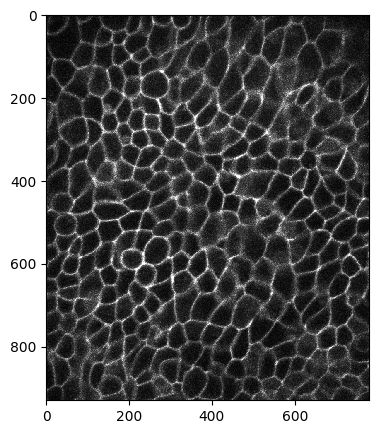

In [16]:
# (v) Look at the image to confirm that everything worked as intended

# To plot an array as an image, use pyplot's functions 'plt.imshow' followed by 'plt.show'. 
# Check the documentation for 'plt.imshow' and note the parameters that can be specified, such as colormap (cmap)
# and interpolation. Since you are working with scientific data, interpolation is unwelcome, so you should set it 
# to "none". The most common cmap for grayscale images is naturally "gray".
# You may also want to adjust the size of the figure. You can do this by preparing the figure canvas with
# the function 'plt.figure' before calling 'plt.imshow'. The canvas size is adjusted using the keyword argument
# 'figsize' when calling 'plt.figure'.
### YOUR CODE HERE!
plt.figure(figsize=(5,5))
plt.imshow(img, interpolation='none', cmap='gray')
plt.show()

## Preprocessing <a id=prepro></a>

#### Background

The goal of image preprocessing is to prepare or optimize the images to make further analysis easier. Usually, this boils down to increasing the signal-to-noise ratio by removing noise and background and by enhancing structures of interest.

The specific preprocessing steps used in a pipeline depend on the type of sample, the microscopy technique used, the image quality, and the desired downstream analysis. 

The most common operations include:


- Deconvolution
    - Image reconstruction based on information about the PSF of the microscope
    - These days deconvolution is often included with microscope software
    - *Our example images are not deconvolved, but will do just fine regardless*


- Conversion to 8-bit images to save memory / computational time
    - *Our example images are already 8-bit*


- Cropping of images to an interesting region
    - *The field of view in our example images is fine as it is*


- Smoothing of technical noise
    - This is a very common step and usually helps to improve almost any type of downstream analysis
    - Commonly used filters are the `Gaussian filter` and the `median filter`
    - *Here we will be using a Gaussian filter.*


- Corrections of technical artifacts
    - Common examples are uneven illumination and multi-channel bleed-through
    - *Here we will deal with uneven signal by adaptive/local thresholding*


- Background subtraction
    - There are various ways of sutracting background signal from an image
    - Two different types are commonly distinguished:
        - `uniform background subtraction` treats all regions of the image the same
        - `adaptive or local background subtraction` automatically accounts for differences between regions of the image
    - *Here we will do something similar to adaptive background subtraction when we do adaptive thresholding*

#### Gaussian Smoothing

A Gaussian filter smoothens an image by convolving it with a Gaussian-shaped kernel. In the case of a 2D image, the Gaussian kernel is also 2D and will look something like this:

<img src="ipynb_images\gaussian_kernel_grid.png" alt="Gaussian Kernel Figure" style="width: 300px;"/>

How much the image is smoothed by a Gaussian kernel is determined by the standard deviation  of the Gaussian distribution, usually referred to as **sigma** ($\sigma$). A higher $\sigma$ means a broader distribution and thus more smoothing.

**How to choose the correct value of $\sigma$?**

This depends a lot on your images, in particular on the pixel size. In general, the chosen $\sigma$ should be large enough to blur out noise but small enough so the "structures of interest" do not get blurred too much. Usually, the best value for $\sigma$ is simply found by trying out some different options and looking at the result. 

#### <font color='teal'>Exercise</font>

Perform Gaussian smoothing and visualize the result.

Follow the instructions in the comments below.

In [29]:
# (i) Create a variable for the smoothing factor sigma, which should be an integer value

### YOUR CODE HERE!
sigma = 3

# After implementing the Gaussian smoothing function below, you can modify this variable 
# to find the ideal value of sigma.

In [30]:
# (ii) Perform the smoothing on the image

# To do so, use the Gaussian filter function 'ndi.gaussian_filter' from the 
# image processing module 'scipy.ndimage', which was imported at the start of the tutorial. 
# Check out the documentation of scipy to see how to use this function. 
# Allocate the output to a new variable.
### YOUR CODE HERE!
filtered_img = ndi.gaussian_filter(img, sigma)

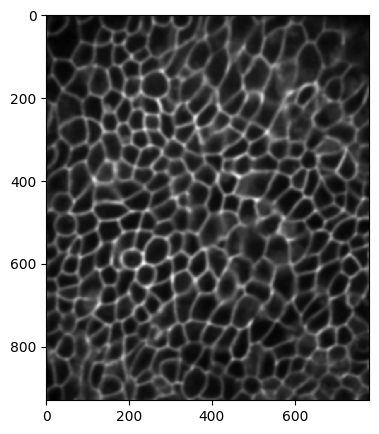

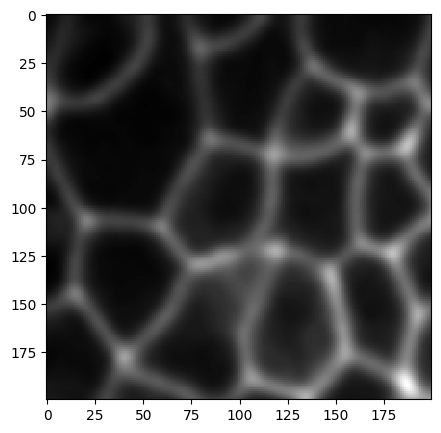

In [34]:
# (iii) Visualize the result using 'plt.imshow'

# Compare with the original image visualized above. 
# Does the output make sense? Is this what you expected? 
# Can you optimize sigma such that the image looks smooth without blurring the membranes too much?
### YOUR CODE HERE!
plt.figure(figsize=(5,5))
plt.imshow(filtered_img, interpolation='none', cmap='gray')
plt.show()

# To have a closer look at a specific region of the image, crop that region out and show it in a 
# separate plot. Remember that you can crop arrays by "indexing" or "slicing" them similar to lists.
# Use such "zoomed-in" views throughout this tutorial to take a closer look at your intermediate 
# results when necessary.
### YOUR CODE HERE!
plt.figure(figsize=(5,5))
plt.imshow(filtered_img[0:200, 0:200], interpolation='none', cmap='gray')
plt.show()

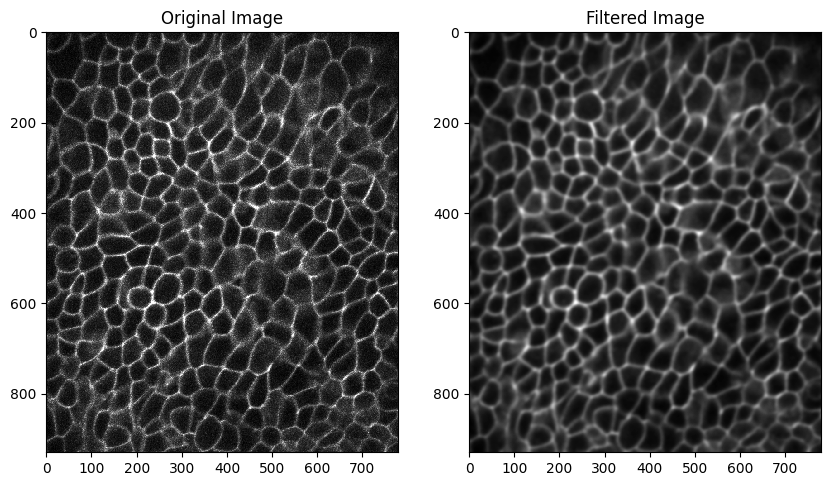

In [38]:
# (iv) BONUS: Show the raw and smoothed images side by side using 'plt.subplots'

### YOUR CODE HERE!
fig, ax = plt.subplots(1, 2, figsize=(10,10)) # fig isthe entire figure, ax is the array of axes objects
ax[0].imshow(img, interpolation='none', cmap='gray')
ax[1].imshow(filtered_img, interpolation='none', cmap='gray')
ax[0].set_title('Original Image')
ax[1].set_title('Filtered Image')
plt.show()

## Manual Thresholding & Threshold Detection <a id=thresh></a>

#### Background

The easiest way to distinguish foreground objects (here: membranes) from the image background is to threshold the image, meaning all pixels with an intensity above a certain threshold are accepted as foreground, all others are set as background.

To find the best threshold for a given image, one option is to simply try out different thresholds manually. Alternatively, one of many algorithms for automated 'threshold detection' can be used. These algorithms use information about the image (such as the histogram) to automatically find a suitable threshold value, often under the assumption that the background and foreground pixels in an image belong to two clearly distinct populations in terms of their intensity. 

There are many different algorithms for threshold detection and it is often hard to predict which one will produce the nicest and most robust result for a particular dataset. It therefore makes sense to try out a bunch of different options.

For this pipeline, we will ultimately use a more advanced thresholding approach, which also accounts (to some extent) for variations in signal across the field of view: adaptive thresholding. 

But first, let's experiment a bit with threshold detection.

#### <font color='teal'>Exercise</font>

Try out manual thresholding and automated threshold detection.

Follow the instructions in the comments below.

In [45]:
# (i) Create a variable for a manually set threshold, which should be an integer

# This can be changed later to find a suitable value.
### YOUR CODE HERE!
threshold = 50

In [46]:
# (ii) Perform thresholding on the smoothed image

# Remember that you can use relational (Boolean) expressions such as 'smaller' (<), 'equal' (==)
# or 'greater or equal' (>=) with numpy arrays - and you can directly assign the result to a new
# variable.
### YOUR CODE HERE!
thresholded_img = filtered_img > threshold

# Check the dtype of your thresholded image
# You should see that the dtype is 'bool', which stands for 'Boolean' and means the array
# is now simply filled with 'True' and 'False', where 'True' is the foreground (the regions
# above the threshold) and 'False' is the background.
### YOUR CODE HERE!
print(thresholded_img.dtype)

bool


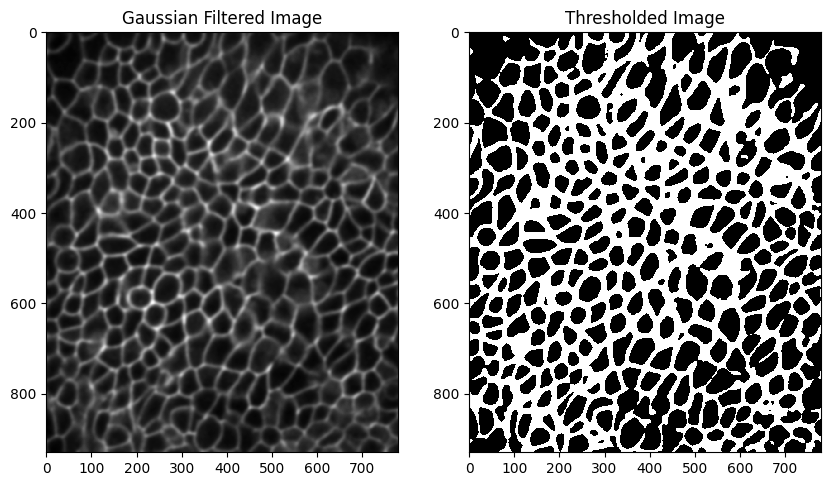

In [47]:
# (iii) Visualize the result

### YOUR CODE HERE!
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(filtered_img, interpolation='none', cmap='gray')
ax[1].imshow(thresholded_img, interpolation='none', cmap='gray')
ax[0].set_title('Gaussian Filtered Image')
ax[1].set_title('Thresholded Image')
plt.show()

In [48]:
# (iv) Try out different thresholds to find the best one

# If you are using jupyter notebook, you can adapt the code below to
# interactively change the threshold and look for the best one. These
# kinds of interactive functions are called 'widgets' and are very 
# useful in exploratory data analysis to create greatly simplified
# 'User Interfaces' (UIs) on the fly.
# As a BONUS exercise, try to understand or look up how the widget works
# and play around with it a bit!
# (Note: If this just displays a static image without a slider to adjust
#        the threshold or if it displays a text warning about activating
#        the 'widgetsnbextension', check out the note below!)

# Prepare widget
from ipywidgets import interact
@interact(thresh=(10,250,10)) # from 10 - 250, increments of 10
def select_threshold(thresh=100):
    
    # Thresholding
    ### ADAPT THIS: Change 'img_smooth' into the variable you stored the smoothed image in!
    mem = filtered_img > thresh
    
    # Visualization
    plt.figure(figsize=(7,7))
    plt.imshow(mem, interpolation='none', cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=100, description='thresh', max=250, min=10, step=10), Output()), _dom_cl…

----

*Important note for those who get a static image (no slider) or a text warning:*

For some users, it is necessary to specifically activate the widgets plugin for Jupyter notebook. To do so, save and exit Jupyter notebook, then go to a terminal (or Anaconda prompt) and write `jupyter nbextension enable --py --sys-prefix widgetsnbextension`. After this, you should be able to restart Jupyter notebook and the widget should display correctly. 

If it still doesn't work, you may instead have to type `jupyter nbextension enable --py widgetsnbextension` in the terminal (or Anaconda prompt). However, note that this implies that your installation of Conda/Jupyter is not optimally configured (see [this GitHub issue](https://github.com/jupyter-widgets/ipywidgets/issues/541) for more information, although this is not something you necessarily need to worry about in the context of this course).

----

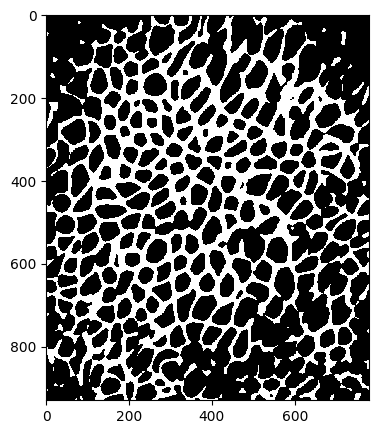

In [49]:
# (v) Perfom automated threshold detection with Otsu's method

# The scikit-image module 'skimage.filters.thresholding' provides
# several threshold detection algorithms. The most popular one 
# among them is Otsu's method. Using what you've learned so far,
# import the 'threshold_otsu' function, use it to automatically 
# determine a threshold for the smoothed image, apply the threshold,
# and visualize the result.
### YOUR CODE HERE!
from skimage.filters.thresholding import threshold_otsu

auto_threshold = threshold_otsu(filtered_img)
auto_thresholded_img = filtered_img > auto_threshold

plt.figure(figsize=(5,5))
plt.imshow(auto_thresholded_img, interpolation='none', cmap='gray')
plt.show()

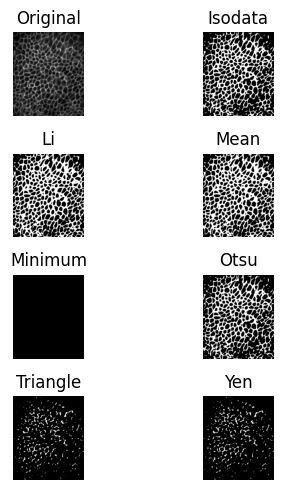

In [52]:
# (vi) BONUS: Did you notice the 'try_all_threshold' function?

# That's convenient! Use it to automatically test the threshold detection
# functions in 'skimage.filters.thresholding'. Don't forget to adjust the
# 'figsize' parameter so the resulting images are clearly visible.
### YOUR CODE HERE!
from skimage.filters.thresholding import try_all_threshold
fig = try_all_threshold(filtered_img, figsize=(5,5), verbose=False)

## Adaptive Thresholding <a id=adaptive></a>

#### Background

Simply applying a fixed intensity threshold does not always produce a foreground mask of sufficiently high quality, since background and foreground intensities often vary across the image. In our example image, for instance, the intensity drops at the image boundaries - a problem that cannot be resolved just by changing the threshold value.

One way of addressing this issue is to use an *adaptive thresholding* algorithm, which adjusts the threshold locally in different regions of the image to account for varying intensities.

Although `scikit-image` provides a function for adaptive thresholding (called `threshold_local`), we will here implement our own version, which is slightly different and will hopefully make the concept of adaptive thresholding very clear.

Our approach to adaptive tresholding works in two steps:

1. Generation of a "background image"

 This image should - across the entire image - always have higher intensities than the local background but lower intensities than the local foreground. This can be achieved by strong blurring/smoothing of the image, as illustrated in this 1D example:

 <img src="ipynb_images\adaptive_bg_1D.png" alt="Adaptive Background Figure" style="width: 400px;"/><br>
    
2. Thresholding of the original image with the background

 Instead of thresholding with a single value, every pixel in the image is thresholded with the corresponding pixel of the "background image".

#### <font color='teal'> Exercise </font>

Implement the two steps of the adaptive background subtraction:

1. Use a strong "mean filter" (aka "uniform filter") to create the background image. This simply assigns each pixel the average value of its local neighborhood. Just like the Gaussian blur, this can be done by convolution, but this time using a "uniform kernel" like this one:

 <img src="ipynb_images\uniform_filter_SE.png" alt="Uniform Filter SE Figure" style="width: 300px;"/>
    
 To define which pixels should be considered as the local neighborhood of a given pixel, a `structuring element` (`SE`) is    used. This is a small binary image where all pixels set to `1` will be considered as part of the neighborhood and all pixels set to `0` will not be considered. Here, we use a disc-shaped `SE`, as this reduces artifacts compared to a square `SE`.
  
 *Side note:* A strong Gaussian blur would also work to create the background mask. For the Gaussian blur, the analogy to the `SE` is the `sigma` value, which in a way also determines the size of the local neighborhood.<br><br>

2. Use the background image for thresholding. In practical terms, this works in exactly the same way as thresholding with a single value, since numpy arrays will automatically perform element-wise (pixel-by-pixel) comparisons when compared to other arrays of the same shape by a relational (Boolean) expression.

Follow the instructions in the comments below.

In [ ]:
# Step 1
# ------

# (i) Create a disk-shaped structuring element and asign it to a new variable.

# Structuring elements are small binary images that indicate which pixels 
# should be considered as the 'neighborhood' of the central pixel. 
#
# An example of a small disk-shaped SE would be this:
#   0 0 1 0 0
#   0 1 1 1 0
#   1 1 1 1 1
#   0 1 1 1 0
#   0 0 1 0 0
#
# The expression below creates such structuring elements. 
# It is an elegant but complicated piece of code and at the moment it is not 
# necessary for you to understand it in detail. Use it to create structuring 
# elements of different sizes (by changing 'i') and find a way to visualize 
# the result (remember that the SE is just a small 'image').
# 
# Try to answer the following questions: 
#   - Is the resulting SE really circular? 
#   - Could certain values of 'i' cause problems? If so, why?
#   - What value of 'i' should be used for the SE?
#     Note that, similar to the sigma in Gaussian smoothing, the size of the SE
#     is first estimated based on the images and by thinking about what would 
#     make sense. Later it can be optimized by trial and error.

# Create SE
i = ???
struct = (np.mgrid[:i,:i][0] - np.floor(i/2))**2 + (np.mgrid[:i,:i][1] - np.floor(i/2))**2 <= np.floor(i/2)**2

# Visualize the result
### YOUR CODE HERE!

In [ ]:
# (ii) Create the background

# Run a mean filter over the image using the disc SE and assign the output to a new variable.
# Use the function 'skimage.filters.rank.mean'.
### YOUR CODE HERE!

In [ ]:
# (iii) Visualize the resulting background image. Does what you get make sense?

### YOUR CODE HERE!

In [ ]:
# Step 2
# ------

# (iv) Threshold the Gaussian-smoothed original image against the background image created in step 1 
#      using a relational expression

### YOUR CODE HERE!

In [ ]:
# (v) Visualize and understand the output. 

### YOUR CODE HERE!

# What do you observe? 
# Are you happy with this result as a membrane segmentation? 
# Adapt the size of the circular SE to optimize the result!

## Improving Masks with Binary Morphology <a id=morpho></a>

#### Background

Morphological operations such as `erosion`, `dilation`, `closing` and `opening` are common tools used to improve masks after they are generated by thresholding. They can be used to fill small holes, remove noise, increase or decrease the size of an object, or smoothen mask outlines.

Most morphological operations are once again simple kernel functions that are applied at each pixel of the image based on their neighborhood as defined by a `structuring element` (`SE`). For example, `dilation` simply assigns to the central pixel the maximum pixel value within the neighborhood; it is a maximum filter. Conversely, `erosion` is a minimum filter. Additional options emerge from combining the two: `morphological closing`, for example, is a `dilation` followed by an `erosion`. This is used to fill in gaps and holes or smoothing mask outlines without significantly changing the mask's area. Finally, there are also some more complicated morphological operations, such as `hole filling`.

#### <font color='teal'>Exercise</font>

Improve the membrane segmentation from above with morphological operations.

Specifically, use `binary hole filling` to get rid of the speckles of foreground pixels that litter the insides of the cells. Furthermore, try different other types of morphological filtering to see how they change the image and to see if you can improve the membrane mask even more, e.g. by filling in gaps.

Follow the instructions in the comments below. Visualize all intermediate results of your work and remember to "zoom in" to get a closer look by slicing out and then plotting a subsection of the image array.

In [ ]:
# (i) Get rid of speckles using binary hole filling

# Use the function 'ndi.binary_fill_holes' for this. Be sure to check the docs to
# understand exactly what it does. For this to work as intended, you will have to 
# invert the mask, which you can do using the function `np.logical_not` or the
# corresponding operator '~'. Again, be sure to understand why this has to be done
# and don't forget to revert the result back.

### YOUR CODE HERE!

In [ ]:
# (ii) Try out other morphological operations to further improve the membrane mask

# The various operations are available in the ndimage module, for example 'ndi.binary_closing'.
# Play around and see how the different functions affect the mask. Can you optimize the mask, 
# for example by closing gaps?
# Note that the default SE for these functions is a square. Feel free to create another disc-
# shaped SE and see how that changes the outcome.
# BONUS: If you pay close attention, you will notice that some of these operations introduce 
# artefacts at the image boundaries. Can you come up with a way of solving this? (Hint: 'np.pad')

### YOUR CODE HERE!

In [ ]:
# (iii) Visualize the final result

### YOUR CODE HERE

# At this point you should have a pretty neat membrane mask.
# If you are not satisfied with the quality your membrane segmentation, you should go back 
# and fine-tune the size of the SE in the adaptive thresholding section and also optimize
# the morphological cleaning operations.
# Note that the quality of the membrane segmentation will have a significant impact on the 
# cell segmentation we will perform next.

## Connected Components Labeling <a id=label></a>

#### Background

Based on the membrane segmentation, we can get a preliminary segmentation of the cells in the image by considering each background region surrounded by membranes as a cell. This can already be good enough for many simple measurements.

The only thing we still need to do in order to get there is to label each cell individually. Only if each separate cell has a unique number (an `ID`) assigned, values such as the mean intensity can be measured and analyzed at the single-cell level.

The approach used to achieve this is called `connected components labeling`. It gives every connected group of foreground pixels a unique `ID` number.

#### <font color='teal'>Exercise</font>

Use your membrane segmentation for connected components labeling.

Follow the instructions in the comments below.

In [ ]:
# (i) Label connected components

# Use the function 'ndi.label' from the 'ndimage' module. 
# Note that this function labels foreground pixels (1s, not 0s), so you may need 
# to invert your membrane mask just as for hole filling above.
# Also, note that 'ndi.label' returns another result in addition to the labeled 
# image. Read up on this in the function's documentation and make sure you don't
# mix up the two outputs!

### YOUR CODE HERE!

In [ ]:
# (ii) Visualize the output

# Here, it is no longer ideal to use a 'gray' colormap, since we want to visualize that each
# cell has a unique ID. Play around with different colormaps (check the docs to see what
# types of colormaps are available) and choose one that you are happy with.

### YOUR CODE HERE!

# Take a close look at the picture and note mistakes in the segmentation. Depending on the
# quality of your membrane mask, there will most likely be some cells that are 'fused', meaning 
# two or more cells are labeled as the same cell; this is called "under-segmentation". 
# We will resolve this issue in the next step. Note that our downstream pipeline does not involve 
# any steps to resolve "over-segmentation" (i.e. a cell being wrongly split into multiple labeled
# areas), so you should tune your membrane mask such that this is not a common problem.

## Cell Segmentation by Seeding & Expansion <a id=seg></a>

#### Background

The segmentation we achieved by membrane masking and connected components labeling is a good start. We could for example use it to measure the fluorescence intensity in each cell's cytoplasm. However, we cannot use it to measure intensities at the membrane of the cells, nor can we use it to accurately measure features like cell shape or size.

To improve this (and to resolve cases of under-segmentation), we can use a "seeding & expansion" strategy. Expansion algorithms such as the `watershed` start from a small `seed` and "grow outward" until they touch the boundaries of neighboring cells, which are themselves growing outward from neighboring seeds. Since the "growth rate" at the edge of the growing areas is dependent on image intensity (higher intensity means slower expansion), these expansion methods end up tracing the cells' outlines.

### Seeding by Distance Transform

#### Background

A `seed image` contains a few pixels at the center of each cell labeled by a unique `ID` number and surrounded by zeros. The expansion algorithm will start from these central pixels and grow outward until all zeros are overwritten by an `ID` label. In the case of `watershed` expansion, one can imagine the `seeds` as the sources from which water pours into the cells and starts filling them up.

For multi-channel images that contain a nuclear label, it is common practice to mask the nuclei by thresholding and use an eroded version of the nuclei as seeds for cell segmentation. However, there are good alternative seeding approaches for cases where nuclei are not available or not nicely separable by thresholding.

Here, we will use a `distance transform` for seeding. In a `distance transform`, each pixel in the foreground (here the cells) is assigned a value corresponding to its distance from the closest background pixel (here the membrane segmentation). In other words, we encode within the image how far each pixel of a cell is away from the membrane (see figure below). The pixels furthest away from the membrane will be at the center of the cells and will have the highest values. Using a function to detect `local maxima`, we will find these high-value peaks and use them as seeds for our segmentation.

<img src="ipynb_images\distance_transform.png" alt="Distance Transform Figure" style="width: 900px;"/>

One big advantage of this approach is that it will create two separate seeds even if two cells are connected by a hole in the membrane segmentation. Thus, under-segmentation artifacts will be reduced.

#### <font color='teal'> Exercise </font>

Find seeds using the distance transform approach.

This involves the following three steps:

1. Run the distance transform on your membrane mask.

2. Due to irregularities in the membrane shape, the distance transform may have some smaller local maxima in addition to those at the center of the cells. This will lead to additional seeds, which will lead to over-segmentation. To resolve this problem, smoothen the distance transform using Gaussian smoothing. 

3. Find the seeds by detecting local maxima. Optimize the seeding by changing the amount of smoothing done in step 2, aiming to have exactly one seed for each cell (although this may not be perfectly achievable).

Follow the instructions in the comments below.

In [ ]:
# (i) Run a distance transform on the membrane mask

# Use the function 'ndi.distance_transform_edt'.
# You may need to invert your membrane mask so the distances are computed on
# the cells, not on the membranes.
### YOUR CODE HERE!

In [ ]:
# (ii) Visualize the output and understand what you are seeing.

### YOUR CODE HERE!

In [ ]:
# (iii) Smoothen the distance transform

# Use 'ndi.gaussian_filter' to do so.
# You will have to optimize your choice of 'sigma' based on the outcome below.
### YOUR CODE HERE!

In [ ]:
# (iv) Retrieve the local maxima (the 'peaks') from the distance transform

# Use the function 'peak_local_max' from the module 'skimage.feature'. By default, this function will return the
# indices (aka coordinates) of the pixels where the local maxima are. However, we instead need a boolean mask of 
# the same shape as the original image, where all the local maximum pixels are labeled as `1` and everything else 
# as `0`. The documentation for `peak_local_max` shows how to convert the coordinates into a Boolean mask using
# numpy (see the last of the examples in the docs). This is a bit of a technical detail, though, so feel free to
# copy the conversion from the solutions.

# Retrieve peak coordinates
### YOUR CODE HERE!

# Convert coords to mask as per skimage documentation
### YOUR CODE HERE!

In [ ]:
# (v) Visualize the output as an overlay on the raw (or smoothed) image

# If you just look at the local maxima image, it will simply look like a bunch of distributed dots.
# To get an idea if the seeds are well-placed, you will need to overlay these dots onto the original image.

# To do this, it is important to first understand a key point about how the 'pyplot' module works: 
# every plotting command is slapped on top of the previous plotting commands, until everything is ultimately 
# shown when 'plt.show' is called. Hence, you can first plot the raw (or smoothed) input image and then
# plot the seeds on top of it before showing both with 'plt.show'.

# As you can see if you try this, you will not get the desired result because the zero values in seed array
# are painted in black over the image you want in the background. To solve this problem, you need to mask 
# these zero values before plotting the seeds. You can do this by creating an appropriately masked array
# using the function 'np.ma.array' with the keyword argument 'mask'. 
# Check the docs or Stack Overflow to figure out how to do this.

# BONUS: As an additional improvement for the visualization, use 'ndi.maximum_filter' to dilate the 
# seeds a little bit, making them bigger and thus better visible.

### YOUR CODE HERE!

In [ ]:
# (vi) Optimize the seeding

# Ideally, there should be exactly one seed for each cell.
# If you are not satisfied with your seeding, go back to the smoothing step above and optimize 'sigma'
# to get rid of additional maxima. You can also try using the keyword argument 'min_distance' in 
# 'peak_local_max' to solve cases where there are multiple small seeds at the center of a cell. Note 
# that good seeding is essential for a good segmentation with an expansion algorithm. However, no 
# segmentation is perfect, so it's okay if a few cells end up being oversegmented.

In [ ]:
# (vii) Label the seeds

# Use connected component labeling to give each cell seed a unique ID number.
### YOUR CODE HERE!

# Visualize the final result (the labeled seeds) as an overlay on the raw (or smoothed) image
### YOUR CODE HERE!

### Expansion by Watershed

#### Background

To achieve a cell segmentation, the `seeds` now need to be expanded outward until they follow the outline of the cell. The most commonly used expansion algorithm is the `watershed`.

Imagine the intensity in the raw/smoothed image as a topographical height profile; high-intensity regions are peaks, low-intensity regions are valleys. In this representation, cells are deep valleys (with the seeds at the center), enclosed by mountains. As the name suggests, the `watershed` algorithm can be understood as the gradual filling of this landscape with water, starting from the seed. As the water level rises, the seed expands - until it finally reaches the 'crest' of the cell membrane 'mountain range'. Here, the water would flow over into the neighboring valley, but since that valley is itself filled up with water from the neighboring cell's seed, the two water surfaces touch and the expansion stops.

<img src="ipynb_images\watershed_illustration.png" alt="Watershed Figure" style="width: 900px;"/>

#### <font color='teal'>Exercise</font>

Expand your seeds by means of a watershed expansion.

Follow the instructions in the comments below.

In [ ]:
# (i) Perform watershed

# Use the function 'watershed' from the module 'skimage.segmentation'.
# Use the labeled cell seeds and the smoothed membrane image as input.
### YOUR CODE HERE!

In [ ]:
# (ii) Show the result as transparent overlay over the smoothed input image

# Like the masked overlay of the seeds, this can be achieved by making two calls to 'imshow',
# one for the background image and one for the segmentation. Instead of masking away background,
# this time you simply make the segmentation image semi-transparent by adjusting the keyword 
# argument 'alpha' of the 'imshow' function, which specifies opacity.
# Be sure to choose an appropriate colormap that allows you to distinguish the segmented cells
# even if cells with a very similar ID are next to each other (I would recommend 'prism').
### YOUR CODE HERE!

#### *A Note on Segmentation Quality*

This concludes the segmentation of the cells in the example image. Depending on the quality you achieved in each step along the way, the final segmentation may be of greater or lesser quality (in terms of over-/under-segmentation errors).

It should be noted that the segmentation will likely *never* be perfect, as there is usually a trade-off between over- and undersegmentation.

This raises an important question: ***When should I stop trying to optimize my segmentation?***

There is no absolute answer to this question but the best answer is probably this: ***When you can use it to address your biological questions!***

*Importantly, this implies that you should already have relatively clear questions in mind when you are working on the segmentation!*

## Postprocessing: Removing Cells at the Image Border <a id=postpro></a>

#### Background

Since segmentation is never perfect, it often makes sense to explicitely remove artifacts afterwards. For example, one could filter out objects that are too small, have a very strange shape, or very strange intensity values. 

**Warning:** Filtering out objects is equivalent to the *removal of outliers* in data analysis and *should only be done for good reason and with caution!*

As an example of postprocessing, we will now filter out a particular group of problematic cells: those that are being cut off at the image border.

#### <font color='teal'> Exercise </font>

Iterate through all the cells in your segmentation and remove those touching the image border.

Follow the instructions in the comments below. Note that the instructions will get a little less specific from here on, so you need to figure out how to approach a problem yourself.

In [ ]:
# (i) Create an image border mask

# We need some way to check if a cell is at the border. For this, we generate a 'mask' of the image border,
# i.e. a Boolean array of the same size as the image where only the border pixels are set to `1` and all 
# others to `0`, like this:
#   1 1 1 1 1
#   1 0 0 0 1
#   1 0 0 0 1
#   1 0 0 0 1
#   1 1 1 1 1
# There are multiple ways of generating this mask, for example by erosion or by array indexing.
# It is up to you to find a way to do it.

### YOUR CODE HERE!

In [ ]:
# (ii) 'Delete' the cells at the border

# When modifying a segmentation (in this case by deleting some cells), it makes sense
# to work on a copy of the array, not on the original. This avoids unexpected behaviors,
# especially within jupyter notebooks. Use the function 'np.copy' to copy an array.
### YOUR CODE HERE!

# Iterate over the IDs of all the cells in the segmentation. Use a for-loop and the 
# function 'np.unique' (remember that each cell in our segmentation is labeled with a 
# different integer value).
### YOUR CODE HERE!

    # Create a mask that contains only the 'current' cell of the iteration
    # Hint: Remember that the comparison of an array with some number (array==number)
    #       returns a Boolean mask of the pixels in 'array' whose value is 'number'.
    ### YOUR CODE HERE!
    
    # Using the cell mask and the border mask from above, test if the cell has pixels touching 
    # the image border or not.
    # Hint: 'np.logical_and'
    ### YOUR CODE HERE!

    # If a cell touches the image boundary, delete it by setting its pixels in the segmentation to 0.
    ### YOUR CODE HERE!


In [ ]:
# OPTIONAL: re-label the remaining cells to keep the numbering consistent from 1 to N (with 0 as background).

### YOUR CODE HERE!

In [ ]:
# (iii) Visualize the result

# Show the result as transparent overlay over the raw or smoothed image. 
# Here you have to combine alpha (to make cells transparent) and 'np.ma.array'
# (to hide empty space where the border cells were deleted).

### YOUR CODE HERE!

## Identifying Cell Edges <a id=edges></a>

#### Background

With the final segmentation in hand, we can now start to think about measurements and data analysis. However, to extract interesting measurements from our cells, the segmentation on its own is often not enough: additional masks that identify sub-regions for each cell allow more precise and more biologically relevant measurements.

The most useful example of this is an additional mask that identifies only the edge pixels of each cell. This is useful for a number of purposes, including:

- Edge intensity is a good measure of membrane intensity, which is often a desired readout.
- The intensity profile along the edge may contain information on cell polarity.
- The length of the edge (relative to the cell area) is an informative feature about the cell shape. 
- Showing colored edges is a nice way of visualizing cell segmentations.

There are many ways of identifying edge pixels in a fully labeled segmentation. Here, we will use a simple and relatively fast method based on erosion.

#### <font color='teal'> Exercise </font>

Create a labeled mask of cell edges by following these steps:


- Create an array of the same size and data type as the segmentation but filled with only zeros
    - This will be your final cell edge mask; you gradually add cell edges as you iterate over cells
    

- *For each cell...*
    - Erode the cell's mask by 1 pixel
    - Using the eroded mask and the original mask, create a new mask of only the cell's edge pixels
    - Add the cell's edge pixels into the empty image generated above, labeling them with the cell's original ID number


Follow the instructions in the comments below.

In [ ]:
# (i) Create an array of the same size and data type as the segmentation but filled with only zeros

### YOUR CODE HERE!

In [ ]:
# (ii) Iterate over the cell IDs
### YOUR CODE HERE!

    # (iii) Erode the cell's mask by 1 pixel
    # Hint: 'ndi.binary_erode'
    ### YOUR CODE HERE!
    
    # (iv) Create the cell edge mask
    # Hint: 'np.logical_xor'
    ### YOUR CODE HERE!
    
    # (v) Add the cell edge mask to the empty array generated above, labeling it with the cell's ID
    ### YOUR CODE HERE!

In [ ]:
# (vi) Visualize the result

# Note: Because the lines are so thin (1pxl wide), they may not be displayed correctly in small figures.
#       You can 'zoom in' by showing a sub-region of the image which is then rendered bigger. You can
#       also go back to the edge identification code and make the edges multiple pixels wide (but keep 
#       in mind that this will have an effect on your quantification results!).

### YOUR CODE HERE!

## Extracting Quantitative Measurements <a id=measure></a>

#### Background

The ultimate goal of image segmentation is of course the extraction of quantitative measurements, in this case on a single-cell level. Measures of interest can be based on intensity (in different channels) or on the size and shape of the cells.

To exemplify how different properties of cells can be measured, we will extract the following:

- Cell ID (so all other measurements can be traced back to the cell that was measured)
- Mean intensity of each cell
- Mean intensity at the membrane of each cell
- The cell area, i.e. the number of pixels that make up the cell
- The cell outline length, i.e. the number of pixels that make up the cell edge

*Note: It makes sense to use smoothed/filtered/background-subtracted images for segmentation. When it comes to measurements, however, it's best to get back to the raw data!*

#### <font color='teal'>Exercise</font>

Extract the measurements listed above for each cell and collect them in a dictionary.

Note: The ideal data structure for data like this is the `DataFrame` offered by the module `Pandas`. However, for the sake of simplicity, we will here stick with a dictionary of lists.

Follow the instructions in the comments below.

In [ ]:
# (i) Create a dictionary that contains a key-value pairing for each measurement

# The keys should be strings describing the type of measurement (e.g. 'intensity_mean') and 
# the values should be empty lists. These empty lists will be filled with the results of the
# measurements.

### YOUR CODE HERE!

In [ ]:
# (ii) Record the measurements for each cell

# Iterate over the segmented cells ('np.unique').
# Inside the loop, create a mask for the current cell and use it to extract the measurements listed above. 
# Add them to the appropriate list in the dictionary using the 'append' method.
# Hint: Remember that you can get out all the values within a masked area by indexing the image 
#       with the mask. For example, 'np.mean(image[cell_mask])' will return the mean of all the 
#       intensity values of 'image' that are masked by 'cell_mask'!

### YOUR CODE HERE!

In [ ]:
# (iii) Print the results and check that they make sense

### YOUR CODE HERE!

## Simple Analysis & Visualisation <a id=analysis></a>

#### Background

By extracting quantitative measurements from an image we cross over from 'image analysis' to 'data analysis'. 

This section briefly explains how to do basic data analysis and plotting, including boxplots, scatterplots and linear fits. It also showcases how to map data back onto the image, creating an "image-based heatmap".

#### <font color='teal'>Exercise</font>

Analyze and plot the extracted data in a variety of ways.

Follow the instructions in the comments below.

In [ ]:
# (i) Familiarize yourself with the data structure of the results dict and summarize the results

# Recall that dictionaries are unordered; a dataset of interest is accessed through its key.
# In our case, the datasets inside the dict are lists of values, ordered in the same order
# as the cell IDs. 

# For each dataset in the results dict, print its name (the key) along with its mean, standard 
# deviation, maximum, minimum, and median. The appropriate numpy methods (e.g. 'np.median') work
# with lists just as well as with arrays.

### YOUR CODE HERE!

In [ ]:
# (ii) Create a box plot showing the mean cell and mean membrane intensities for both channels. 

# Use the function 'plt.boxplot'. Use the 'label' keyword of 'plt.boxplot' to label the x axis with 
# the corresponding key names. Feel free to play around with the various options of the boxplot 
# function to make your plot look nicer. Remember that you can first call 'plt.figure' to adjust 
# settings such as the size of the plot.

### YOUR CODE HERE!

In [ ]:
# (iii) Create a scatter plot of cell outline length over cell area

# Use the function 'plt.scatter' for this. Be sure to properly label the 
# plot using 'plt.xlabel' and 'plt.ylabel'.
### YOUR CODE HERE!

# BONUS: Do you understand why you are seeing the pattern this produces? Can you
# generate a 'null model' curve that assumes all cells to be circular? What is
# the result? Do you notice something odd about it? What could be the reason for
# this and how could it be fixed?
### YOUR CODE HERE!

In [ ]:
# (iv) Perform a linear fit of membrane intensity over cell area

# Use the function 'linregress' from the module 'scipy.stats'. Be sure to read the docs to
# understand the output of this function. Print the output.

### YOUR CODE HERE!

In [ ]:
# (v) Think about the result

# Note that the fit seems to return a highly significant p-value but a very low correlation 
# coefficient (r-value). Based on prior knowledge, we would not expect a linear correlation of 
# this sort to be present in our data. 
#
# This should prompt several questions:
#   1) What does this p-value actually mean? Check the docs of 'linregress'!
#   2) Could there be artifacts in our segmentation that bias this analysis?
#
# In general, it's always good to be very careful when doing any kind of data analysis. Make sure you 
# understand the functions you are using and always check for possible errors or sources of bias!

In [ ]:
# (vi) Overlay the linear fit onto a scatter plot

# Recall that a linear function is defined by `y = slope * x + intercept`.

# To define the line you'd like to plot, you need two values of x (the starting point and
# and the end point of the line). What values of x make sense? Can you get them automatically?
### YOUR CODE HERE!

# When you have the x-values for the starting point and end point, get the corresponding y 
# values from the fit through the equation above.
### YOUR CODE HERE!

# Plot the line with 'plt.plot'. Adjust the line's properties so it is well visible.
# Note: Remember that you have to create the scatterplot before plotting the line so that
#       the line will be placed on top of the scatterplot.
### YOUR CODE HERE!

# Use 'plt.legend' to add information about the line to the plot.
### YOUR CODE HERE!

# Label the plot and finally show it with 'plt.show'.
### YOUR CODE HERE!

In [ ]:
# (vii) Map the cell area back onto the image as a 'heatmap'

# Scale the cell area data to 8bit so that it can be used as pixel intensity values.
# Hint: if the largest cell area should correspond to the value 255 in uint8, then 
#       the other cell areas correspond to 'cell_area * 255 / largest_cell_area'.
# Hint: To perform an operation on all cell area values at once, convert the list 
#       of cell areas to a numpy array.
### YOUR CODE HERE!

# Initialize a new image array; all values should be zeros, the shape should be identical 
# to the images we worked with before and the dtype should be uint8.
### YOUR CODE HERE!

# Iterate over the segmented cells. In addition to the cell IDs, the for-loop should
# also include a simple counter (starting from 0) with which the area measurement can be 
# accessed by indexing.
### YOUR CODE HERE!
    
    # Mask the current cell and assign the cell's (re-scaled) area value to the cell's pixels.
    ### YOUR CODE HERE!

# Visualize the result as a colored semi-transparent overlay over the raw/smoothed original input image.
# BONUS: See if you can exclude outliers to make the color mapping more informative!
### YOUR CODE HERE!

## Writing Output to Files <a id=write></a>

#### Background

The final step of the pipeline shows how to write various outputs of the pipeline to files.

Data can be saved to files in a human-readable format such as text files (e.g. to import into Excel), in a format readable for other programs such as tif-images (e.g. to view in Fiji) or in a language-specific file that makes it easy to reload the data into python in the future (e.g. for further analysis).

#### <font color='teal'> Exercise </font>

Write the generated data into a variety of different output files.

Follow the instructions in the comments below.

In [ ]:
# (i) Write one or more of the images you produced to a tif file

# Use the function 'imsave' from the 'skimage.io' module. Make sure that the array you are 
# writing is of integer type. If necessary, you can use the method 'astype' for conversions, 
# e.g. 'some_array.astype(np.uint8)' or 'some_array.astype(np.uint16)'. Careful when 
# converting a segmentation to uint8; if there are more than 255 cells, the 8bit format
# doesn't have sufficient bit-depth to represent all cell IDs!
#
# You can also try adding the segmentation to the original image, creating an image with
# two channels, one of them being the segmentation. 
#
# After writing the file, load it into Fiji and check that everything worked as intended.

### YOUR CODE HERE!

In [ ]:
# (ii) Write a figure to a png or pdf

# Recreate the scatter plot from above (with or without the regression line), then save the figure
# as a png using 'plt.savefig'. Alternatively, you can also save it to a pdf, which will create a
# vector graphic that can be imported into programs like Adobe Illustrator.

### YOUR CODE HERE!

In [ ]:
# (iii) Save the segmentation as a numpy file

# Numpy files allow fast storage and reloading of numpy arrays. Use the function 'np.save'
# to save the array and reload it using 'np.load'.

### YOUR CODE HERE!

In [ ]:
# (iv) Save the result dictionary as a pickle file

# Pickling is a way of generating generic files from almost any python object, which can easily
# be reloaded into python at a later point in time.
# You will need to open an empty file object using 'open' in write-bytes mode ('wb'). It's best to  
# do so using the 'with'-statement (context manager) to make sure that the file object will be 
# closed automatically when you are done with it.
# Use the function 'pickle.dump' from the 'pickle' module to write the results to the file.
# Hint: Refer to the python documention for input and output to understand how file objects are
#       handled in python in general.

### YOUR CODE HERE!

## Note: Pickled files can be re-loaded again as follows:
#with open('my_filename.pkl', 'rb') as infile:
#    reloaded = pickle.load(infile)

In [ ]:
# (v) Write a tab-separated text file of the results dict

# The most generic way of saving numeric results is a simple text file. It can be imported into 
# pretty much any other program.

# To write normal text files, open an empty file object in write mode ('w') using the 'with'-statement.
### YOUR CODE HERE!

    # Use the 'file_object.write(string)' method to write strings to the file, one line at a time,
    # First, write the header of the data (the result dict keys), separated by tabs ('\t'). 
    # It makes sense to first generate a complete string with all the headers and then write this 
    # string to the file as one line. Note that you will need to explicitly write 'newline' characters 
    # ('\n') at the end of the line to switch to the next line.
    # Hint: the string method 'join' is very useful here!
    ### YOUR CODE HERE!

    # After writing the headers, iterate over all the cells and write the result data to the file line
    # by line, by creating strings similar to the header string.
    ### YOUR CODE HERE!

# After writing the data, have a look at the output file in a text editor or in a spreadsheet
# program like Excel.

## Batch Processing <a id=batch></a>

#### Background

In practice, we never work with just a single image, so we would like to make it possible to run our analysis pipeline for multiple images and then collect and analyze all the results. This final section of the tutorial shows how to do just that.

#### <font color='teal'>Exercise</font>

To run a pipeline multiple times, it needs to be packaged into a function or - even better - as a separate module. Jupyter notebook is not well suited for this, so if you're working in a notebook, first extract your code to a `.py` file (see instructions below). If you are not working in a notebook, create a copy of your pipeline; we will modify this copy into a function that can then be called repeatedly for different images.

To export a jupyter notebook as a `.py` file, use `File > Download as > Python (.py)`, then save the file. Open the resulting python script in a text editor or in an IDE like PyCharm. 


#### Let's clean the script a bit:

- Remove the line `%matplotlib [inline|notebook|qt]`. It is not valid python code outside of a Jupyter notebook.


- Go through the script and comment out everything related to plotting; when running a pipeline for dozens or hundreds of images, we usually do not want to generate tons of plots. Similarly, it can make sense to remove some print statments if you have many of them.


- Remove the sections `Manual Thresholding` and `Connected Components Labeling`; they are not used in the final segmentation.


- Remove the sections `Simple Analysis and Visualization` and `Writing Output to Files`; we will collect the output for each image when running the pipeline in a loop. That way, everything can be analyzed at once at the end. 
    - Note that, even though we skip it here, it is often very useful to store every input file's corresponding outputs in new files. When doing so, the output files should use the name of the input file modified with an additional suffix. For example, the results extracted when analyzing `img_1.tif` might best be stored as `img_1_results.pkl`.
    - You can implement this approach for saving the segmentations and/or the result dicts as a *bonus* exercise!


- Feel free to delete some of the background information to make the script more concise.


#### Converting the pipeline to a function:

Convert the entire pipeline into a function that accepts a directory and a filename as input, runs everything, and returns the final segmentation and the results dictionary. To do this, you must:

- Add the function definition statement at the beginning of the script (after the imports)
- Replace the 'hard-coded' directory path and filename by variables that are accepted by the function
- Indent all the code
- Add a return statement at the end


#### Importing the function and running it for multiple input files:

To actually run the pipeline function for multiple input files, we need to do the following:

- Import the pipeline function from the `.py` file
- Iterate over all the filenames in a directory
- For each filename, call the pipeline function
- Collect the returned results

Once you have converted your pipeline into a function as described above, you can import and run it according to the instructions below.

In [ ]:
# (i) Test if your pipeline function actually works

# Import your function using the normal python syntax for imports, like this:
#   from your_module import your_function
# Run the function and visualize the resulting segmentation. Make sure everything works as intended.

### YOUR CODE HERE!

In [ ]:
# (ii) Get all relevant filenames from the input directory

# Use the function 'listdir' from the module 'os' to get a list of all the files
# in a directory. Find a way to filter out only the relevant input files, namely
# "example_cells_1.tif" and "example_cells_2.tif". Of course, one would usually
# do this for many more images, otherwise it's not worth the effort.
# Hint: Loop over the filenames and use if statements to decide which ones to 
#       keep and which ones to throw away.

### YOUR CODE HERE!

In [ ]:
# (iii) Iterate over the input filenames and run the pipeline function

# Be sure to collect the output of the pipeline function in a way that allows
# you to trace it back to the file it came from. You could for example use a
# dictionary with the filenames as keys.

### YOUR CODE HERE!

In [ ]:
# (iv) Recreate one of the scatterplots from above but this time with all the cells

# You can color-code the dots to indicate which file they came from. Don't forget to
# add a corresponding legend.

### YOUR CODE HERE!

## <font color='teal'>*Congratulations! You have completed the tutorial!*</font>

**We hope you enjoyed the ride and learned a lot!**

### Concluding Remarks

It's important to remember that the phrase ***"Use it or loose it!"*** fully applies for the skills taught in this tutorial.

If you now just go back to the lab and don't touch python or image analysis for the next half year, most of the things you have learned here will be lost.

So, what can you do?


- If possible, start applying what you have learned to your own work right away


- Even if your current work doesn't absolutely *need* coding / image analysis (which to be honest is hard to believe! ;p), you can still use it at least to make some nice plots!


- Another very good approach is to find yourself an interesting little side project you can play around with


- Of course, there is still much more to learn and the internet happens to be full of excellent tutorials!
    - As a starting point, have a look at [Bio-IT's curated list of tutorials](https://bio-it.embl.de/coding-club/curated-tutorials/)

***We wish you the best of luck for all your coding endeavors!***